# Project 3: Posture Classification with a Neural Network

This notebook is a complete machine learning pipeline:
1.  Load Data Load all 24 `.csv` files from the `./data/` folder.
2.  Preprocess Add noise, assign labels, scale the data, and split it into train/validation/test sets.
3.  Build Model Define a simple neural network architecture.
4.  Train & Compare: Train three models, one for each activation function (ReLU, Tanh, Sigmoid), and plot their performance.
5.  Evaluate: Select the best model and evaluate its final performance on the hidden test set.

## 1. Imports

Importing all the necessary libraries.

In [12]:
# OS and file system operations
import os
import glob
from io import StringIO

# Data handling and numerical operations
import numpy as np
import pandas as pd

# Data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Scikit-learn for preprocessing and evaluation
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix

# TensorFlow and Keras for building the neural network
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import to_categorical

# Command for Jupyter to display plots inline
%matplotlib inline

## 2. Constants and Configuration

In [13]:
# Define our labels.
CLASS_LABELS = {
    'supine': 0,
    'prone': 1,
    'side': 2,      # Includes 'left_side' and 'right_side'
    'sitting': 3,
    'unknown': 4
}
# Get the total number of classes (5) for our output layer
NUM_CLASSES = len(CLASS_LABELS)

# Folder where I saved my data
DATA_DIR = '/content/data/'

# Defining the amount of noise to add so as to represent real-world deployment of the system
# 0.1 (10%) seems like a reasonable amount to simulate small jitters.
NOISE_LEVEL = 0.1   # (10% of standard deviation)

## 3. Data Loading and Processing

These are the helper functions to load, clean, and prepare all the data files.

In [14]:
def add_noise(data, noise_level):
    """
    Adds Gaussian noise to the sensor data to simulate real-world motion.
    """
    # Check if the data array is not empty
    if data.size > 0:
        # Calculate the standard deviation of the noise to add
        noise_std = noise_level * np.std(data)
        # Generate Gaussian (normal) noise with the same shape as the data
        noise = np.random.normal(0, noise_std, data.shape)
        # Add the noise to the original data
        return data + noise
    # Return the data unmodified if it's empty
    return data

In [15]:
def find_header_and_load(file_path):
    """
    Finds the 'ax,ay,az,gx,gy,gz' header, skipping any
    introductory lines (e.g., "IMU initialized...").
    This makes the loading process robust to my Arduino's startup messages.

    *Citation: This custom header-finding logic was based on a common
    pattern for robust CSV parsing (from StackOverflow answers).*
    """
    # Start by assuming the header is on the first line (index 0)
    header_row_index = 0
    # Open the file and read it line by line
    with open(file_path, 'r') as f:
        # Enumerate gives us both the line index (i) and the line content
        for i, line in enumerate(f):
            # Clean up the line and check if it starts with our header
            if line.strip().lower().startswith('ax,ay,az,gx,gy,gz'):
                # If we find it, save the index
                header_row_index = i
                # Stop searching
                break

    # Finally, read the CSV, telling pandas to skip all rows *before* the header
    df = pd.read_csv(file_path, skiprows=header_row_index)
    return df

In [16]:
def load_data(data_dir):
    """
    Loads all .csv files from the data directory, adds noise,
    and assigns the correct class label.
    """
    # Create empty lists to store all the data and labels
    all_data = []
    all_labels = []

    # Use glob to find all files ending in .csv in my data directory
    csv_files = glob.glob(os.path.join(data_dir, '*.csv'))

    # A quick check to make sure I actually found some files
    if not csv_files:
        print(f"Error: No .csv files found in '{data_dir}'.")
        print("Please create a './data/' folder and put your CSV files inside it.")
        return None, None

    print(f"Found {len(csv_files)} files. Processing...")

    # Loop through every file path we found
    for file_path in csv_files:
        # Get just the filename (e.g., 'supine_usb_up_trial1.csv')
        filename = os.path.basename(file_path).lower()

        # This is my simple, filename-based labeling logic
        label = None
        if 'supine' in filename:
            label = CLASS_LABELS['supine']
        elif 'prone' in filename:
            label = CLASS_LABELS['prone']
        elif 'side' in filename: # This catches 'left_side' and 'right_side'
            label = CLASS_LABELS['side']
        elif 'sitting' in filename:
            label = CLASS_LABELS['sitting']
        elif 'unknown' in filename:
            label = CLASS_LABELS['unknown']

        # Only proceed if we successfully found a label
        if label is not None:
            # Use my robust function to load the dataframe
            df = find_header_and_load(file_path)

            # Make sure the file isn't empty or corrupted
            if df.shape[1] < 6:
                print(f"Warning: Skipping file {filename}, expected 6+ columns, got {df.shape[1]}")
                continue

            # Select only the first 6 columns (ax, ay, az, gx, gy, gz)
            sensor_data = df.iloc[:, :6].values

            # Add Artificial Noise
            sensor_data_noisy = add_noise(sensor_data, NOISE_LEVEL)

            # Add the noisy data to our master list
            all_data.append(sensor_data_noisy)

            # Create a matching label for *every single row* (time-step)
            labels = np.full(sensor_data_noisy.shape[0], label)
            # Add these labels to our master list
            all_labels.append(labels)
        else:
            print(f"Warning: Skipping file '{filename}', unknown class.")

    # Check if we actually loaded any data before proceeding
    if not all_data:
        print("Error: No data was loaded. Check filenames and file content.")
        return None, None

    # Combine all the individual file data into one giant NumPy array
    X = np.concatenate(all_data, axis=0)
    # Do the same for the labels
    y = np.concatenate(all_labels, axis=0)

    # Return the complete dataset
    return X, y

In [17]:
def preprocess_data(X, y):
    """
    Splits the data into train, validation, and test sets, and then
    applies Standard Scaling. This is a crucial step to prevent data leakage.
    """
    # --- Split the data ---
    # 1. Split into (Train + Validation) and Test
    # Holding back 20% of the data for a final, *unseen* test set.
    X_train_val, X_test, y_train_val, y_test = train_test_split(
        X, y,
        test_size=0.2,     # 20% for testing
        random_state=42,   # For reproducible results
        stratify=y         # Keep class balance in the split!
    )

    # 2. Split (Train + Validation) into Train and Validation
    # Using 25% of the remaining 80% for validation (which is 20% of the total)
    # This gives a 60% Train, 20% Validation, 20% Test split.
    X_train, X_val, y_train, y_val = train_test_split(
        X_train_val, y_train_val,
        test_size=0.25, # 25% of 80% = 20%
        random_state=42,
        stratify=y_train_val # Stratify again
    )

    # --- Normalize the data (to prevent data leakage) ---
    # NNs work best with normalized data (mean 0, std 1).
    # Must fit the scaler ONLY on the training data.
    scaler = StandardScaler()
    # Fit the scaler only to X_train
    scaler.fit(X_train)

    # Now, use that same scaler to transform all three sets
    X_train_scaled = scaler.transform(X_train)
    X_val_scaled = scaler.transform(X_val)
    X_test_scaled = scaler.transform(X_test)

    print(f"Data split complete:")
    print(f"  Training samples:   {X_train_scaled.shape[0]}")
    print(f"  Validation samples: {X_val_scaled.shape[0]}")
    print(f"  Test samples:       {X_test_scaled.shape[0]}")

    # Return the scaled data, the (unscaled) labels, and the scaler itself
    return X_train_scaled, X_val_scaled, X_test_scaled, y_train, y_val, y_test, scaler

### Run the Data Pipeline

Execute the functions above to load, process, and split our data.

In [18]:
print("Loading and processing data...")
# Call my load_data function
X, y = load_data(DATA_DIR)

# Only proceed if data loading was successful
if X is not None:
    # Call my preprocess function to split and scale the data
    X_train, X_val, X_test, y_train, y_val, y_test, scaler = preprocess_data(X, y)

    # Define the input shape for the NN. It's (6,) for our 6 features.
    input_shape = (X_train.shape[1],)
    print(f"\nInput shape for model: {input_shape}")
else:
    print("Data loading failed. Please check your 'data' folder and file names.")

Loading and processing data...
Found 24 files. Processing...
Data split complete:
  Training samples:   39588
  Validation samples: 13197
  Test samples:       13197

Input shape for model: (6,)


## 4. Neural Network Architecture

Defining a function to build my model. This makes it easy to create multiple models (for `relu`, `tanh`, and `sigmoid`) with the same architecture.

In [19]:
def build_model(hidden_activation, input_shape):
    """
    Builds a simple Sequential Keras model.
    Takes the hidden layer activation function as a parameter.
    """
    # A Sequential model is a simple, linear stack of layers.
    model = Sequential()

    # --- Input Layer (and first hidden layer) ---
    # A Dense layer is a standard fully-connected layer.
    # 32 neurons is a good starting guess (not too big, not too small).
    model.add(Dense(32, activation=hidden_activation, input_shape=input_shape))

    # --- Regularization ---
    # Dropout randomly 'drops' 30% of neurons during training to prevent overfitting.
    model.add(Dropout(0.3))

    # --- Second hidden layer ---
    # Make one smaller (16 neurons) to condense the features.
    model.add(Dense(16, activation=hidden_activation))

    # --- Output Layer ---
    # This layer MUST have 5 neurons (one for each class).
    # 'softmax' is required to convert the outputs into a probability distribution.
    # (e.g., [0.1, 0.0, 0.8, 0.1, 0.0], meaning 80% chance it's class 2)
    #
    # *Citation: I asked a GenAI "What is the right output layer and loss
    # for multi-class classification with integer labels?" It confirmed
    # 'softmax' and 'sparse_categorical_crossentropy' are the correct choices.*

    model.add(Dense(NUM_CLASSES, activation='softmax'))

    # --- Compile the model ---
    # This configures the model for training.
    model.compile(
        # 'adam' is a good, fast, all-purpose optimizer. It works well.
        optimizer='adam',

        # This is the correct loss function for multi-class classification
        # where the labels are integers (0, 1, 2...) not one-hot arrays.
        loss='sparse_categorical_crossentropy',

        # Track 'accuracy' as the main metric during training.
        metrics=['accuracy']
    )

    return model

## 5. Model Training and Comparison

This is the main part of the project. I will train three separate models to compare the `relu`, `tanh`, and `sigmoid` activation functions, as required.

In [20]:
def plot_history(history, title):
    """
    Plots the training and validation accuracy/loss.
    """
    # Create a figure with 2 side-by-side subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

    # --- Plot accuracy ---
    # Get the 'accuracy' from the training history
    ax1.plot(history.history['accuracy'], label='Train Accuracy')
    # Get the 'val_accuracy' (validation) from the history
    ax1.plot(history.history['val_accuracy'], label='Validation Accuracy')
    ax1.set_title(f'{title} - Accuracy')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Accuracy')
    ax1.legend()

    # --- Plot loss ---
    ax2.plot(history.history['loss'], label='Train Loss')
    ax2.plot(history.history['val_loss'], label='Validation Loss')
    ax2.set_title(f'{title} - Loss')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss')
    ax2.legend()

    # Add a main title to the whole figure
    plt.suptitle(f'Model Training History with {title}', fontsize=16)
    # Show the plot
    plt.show()


 Comparing Activation Functions...

--- Training model with RELU ---


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
1238/1238 - 6s - 5ms/step - accuracy: 0.8668 - loss: 0.5603 - val_accuracy: 0.9976 - val_loss: 0.0270
Epoch 2/100
1238/1238 - 2s - 2ms/step - accuracy: 0.9952 - loss: 0.0340 - val_accuracy: 0.9989 - val_loss: 0.0060
Epoch 3/100
1238/1238 - 2s - 2ms/step - accuracy: 0.9974 - loss: 0.0145 - val_accuracy: 0.9995 - val_loss: 0.0041
Epoch 4/100
1238/1238 - 2s - 2ms/step - accuracy: 0.9977 - loss: 0.0099 - val_accuracy: 0.9995 - val_loss: 0.0030
Epoch 5/100
1238/1238 - 3s - 3ms/step - accuracy: 0.9984 - loss: 0.0067 - val_accuracy: 0.9995 - val_loss: 0.0023
Epoch 6/100
1238/1238 - 3s - 2ms/step - accuracy: 0.9986 - loss: 0.0054 - val_accuracy: 0.9996 - val_loss: 0.0021
Epoch 7/100
1238/1238 - 2s - 2ms/step - accuracy: 0.9989 - loss: 0.0042 - val_accuracy: 0.9996 - val_loss: 0.0020
Epoch 8/100
1238/1238 - 2s - 2ms/step - accuracy: 0.9991 - loss: 0.0033 - val_accuracy: 0.9996 - val_loss: 0.0019
Epoch 9/100
1238/1238 - 3s - 2ms/step - accuracy: 0.9990 - loss: 0.0039 - val_accuracy: 

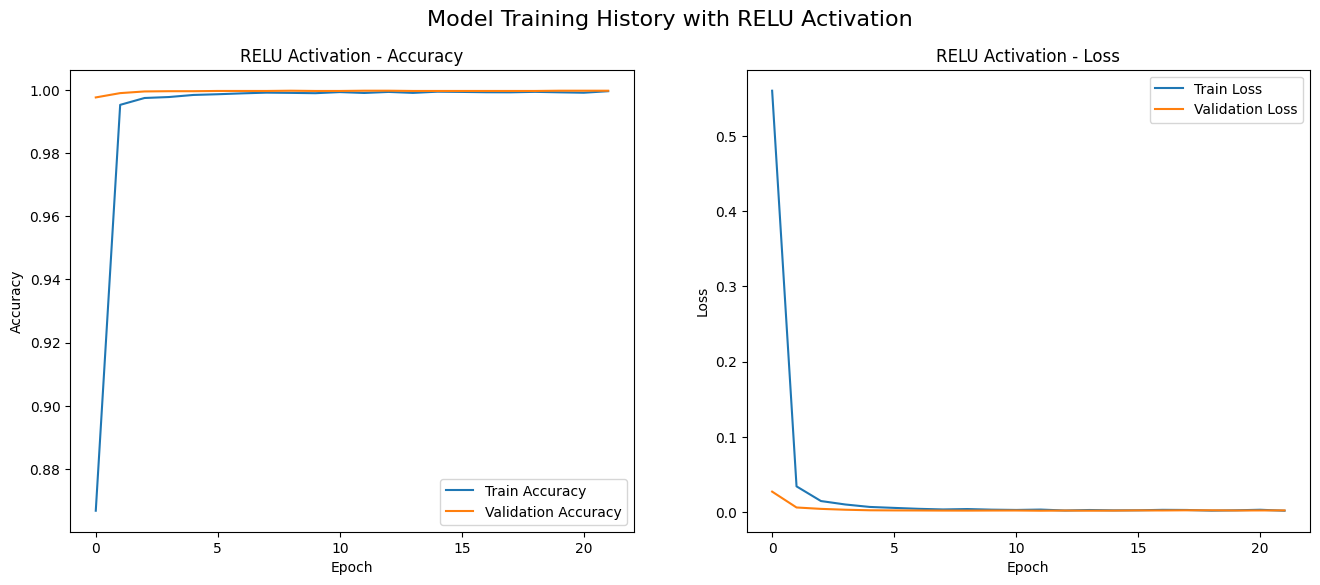


--- Training model with TANH ---
Epoch 1/100
1238/1238 - 4s - 3ms/step - accuracy: 0.6636 - loss: 0.9562 - val_accuracy: 0.9139 - val_loss: 0.3694
Epoch 2/100
1238/1238 - 3s - 2ms/step - accuracy: 0.9539 - loss: 0.2318 - val_accuracy: 0.9875 - val_loss: 0.0938
Epoch 3/100
1238/1238 - 2s - 2ms/step - accuracy: 0.9838 - loss: 0.0929 - val_accuracy: 0.9924 - val_loss: 0.0461
Epoch 4/100
1238/1238 - 2s - 2ms/step - accuracy: 0.9895 - loss: 0.0560 - val_accuracy: 0.9936 - val_loss: 0.0305
Epoch 5/100
1238/1238 - 2s - 2ms/step - accuracy: 0.9915 - loss: 0.0404 - val_accuracy: 0.9946 - val_loss: 0.0238
Epoch 6/100
1238/1238 - 4s - 3ms/step - accuracy: 0.9933 - loss: 0.0320 - val_accuracy: 0.9958 - val_loss: 0.0174
Epoch 7/100
1238/1238 - 5s - 4ms/step - accuracy: 0.9941 - loss: 0.0253 - val_accuracy: 0.9960 - val_loss: 0.0156
Epoch 8/100
1238/1238 - 4s - 4ms/step - accuracy: 0.9952 - loss: 0.0208 - val_accuracy: 0.9968 - val_loss: 0.0126
Epoch 9/100
1238/1238 - 3s - 3ms/step - accuracy: 0.99

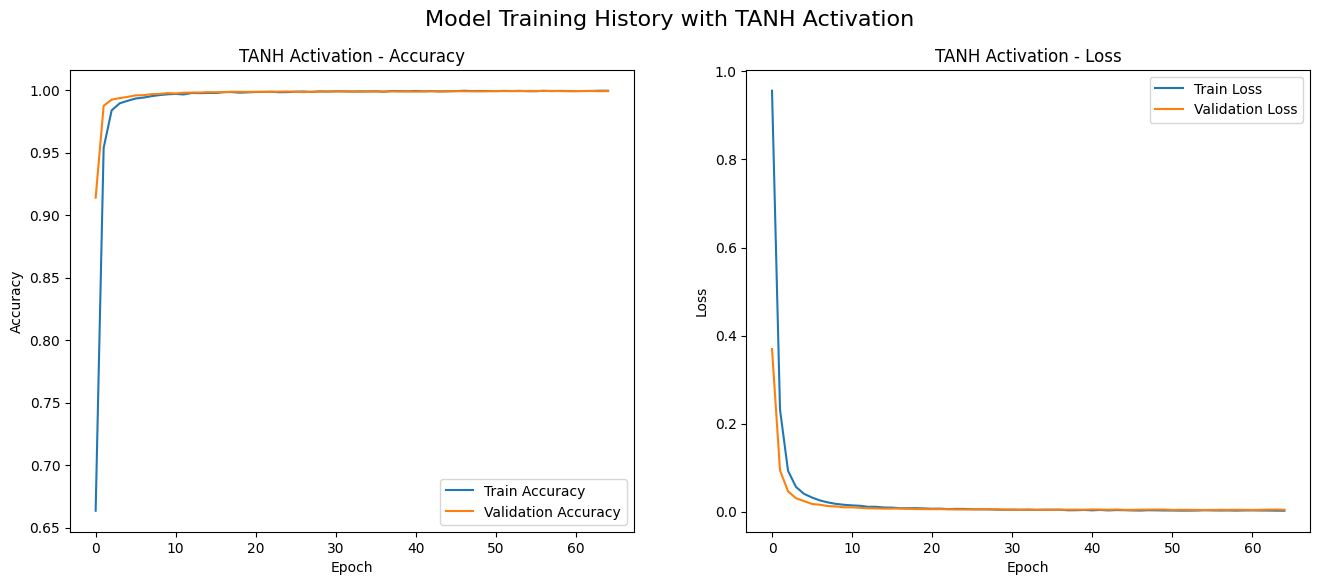


--- Training model with SIGMOID ---
Epoch 1/100
1238/1238 - 4s - 3ms/step - accuracy: 0.3319 - loss: 1.5379 - val_accuracy: 0.3317 - val_loss: 1.4312
Epoch 2/100
1238/1238 - 3s - 3ms/step - accuracy: 0.5063 - loss: 1.2202 - val_accuracy: 0.7034 - val_loss: 0.8990
Epoch 3/100
1238/1238 - 3s - 2ms/step - accuracy: 0.7204 - loss: 0.8022 - val_accuracy: 0.7915 - val_loss: 0.5800
Epoch 4/100
1238/1238 - 2s - 2ms/step - accuracy: 0.7777 - loss: 0.5862 - val_accuracy: 0.8137 - val_loss: 0.4461
Epoch 5/100
1238/1238 - 2s - 2ms/step - accuracy: 0.7974 - loss: 0.4859 - val_accuracy: 0.8231 - val_loss: 0.3901
Epoch 6/100
1238/1238 - 2s - 2ms/step - accuracy: 0.8084 - loss: 0.4385 - val_accuracy: 0.8268 - val_loss: 0.3643
Epoch 7/100
1238/1238 - 3s - 3ms/step - accuracy: 0.8149 - loss: 0.4097 - val_accuracy: 0.8302 - val_loss: 0.3496
Epoch 8/100
1238/1238 - 4s - 3ms/step - accuracy: 0.8190 - loss: 0.3937 - val_accuracy: 0.8319 - val_loss: 0.3402
Epoch 9/100
1238/1238 - 3s - 2ms/step - accuracy: 0

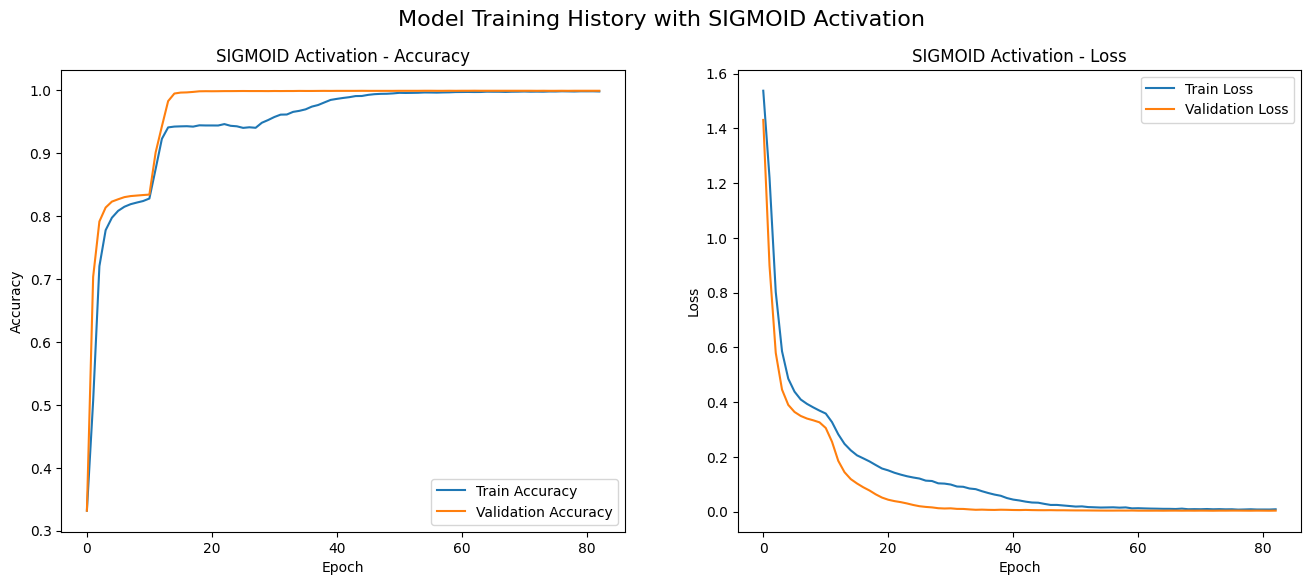

In [21]:
print("\n Comparing Activation Functions...")

# The list of activations to test
activations = ['relu', 'tanh', 'sigmoid']
# Create empty dictionaries to store the results of each model
histories = {}
models = {}

# This is a best practice: Early Stopping
# It will stop training if the validation loss (`monitor='val_loss'`)
# doesn't improve for 10 epochs in a row (`patience=10`).
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    # This is crucial: it restores the model weights from the best epoch,
    # not the last epoch.
    restore_best_weights=True
)

# Now, loop through the activation functions and train a model for each
for act_func in activations:
    print(f"\n--- Training model with {act_func.upper()} ---")
    # Build a new, fresh model for this activation function
    model = build_model(hidden_activation=act_func, input_shape=input_shape)

    # --- This is the main training command ---
    history = model.fit(
        X_train, y_train,        # Training data and labels
        epochs=100,              # A max number of passes over the data
        batch_size=32,           # Process data in chunks of 32
        validation_data=(X_val, y_val), # Data to check against
        callbacks=[early_stopping],     # Use our early stopping rule
        verbose=2                # Print less output during training
    )

    # Save the results
    histories[act_func] = history
    models[act_func] = model

    # Plot the history for this model to see it immediately
    plot_history(history, f'{act_func.upper()} Activation')

## 6. Final Test Set Evaluation

After comparing the three models, selecting the one with the highest validation accuracy and evaluate it on the final, unseen test set. This tells us how well model *really* performs on data it has never seen.

#####*Citation for this Evaluation Block*,
This entire block of code is built using standard, well-documented functions from the Python data science ecosystem. I am citing them here to explain my choices.

**`best_model.predict()` and `np.argmax()`**: This is the standard Keras/NumPy workflow for getting the final class predictions. The model outputs 5 probabilities (due to `softmax`), and `np.argmax` simply finds the index (0-4) with the highest probability, which gives me my predicted class label.

**`classification_report`**: This is a key utility from **Scikit-learn**. I'm using it because it's the standard way to see the model's precision, recall, and f1-score for each class, which is necessary for my report. [Ref: scikit-learn.org]

**`confusion_matrix`**: Also from **Scikit-learn**. This is essential for my report to show *where* the model is getting confused (e.g., is it misclassifying 'side' as 'supine'?). [Ref: scikit-learn.org]

**`sns.heatmap`**: This is from the **Seaborn** library. I'm using it to create a clean, color-coded visualization of the raw confusion matrix, which makes it much easier to read and analyze. [Ref: seaborn.pydata.org]


Final Model Evaluation on Test Set...
Model (relu) best validation accuracy: 0.9997
Model (tanh) best validation accuracy: 0.9994
Model (sigmoid) best validation accuracy: 0.9993

Evaluating best model (RELU) on unseen test data...
413/413 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step

Classification Report:
              precision    recall  f1-score   support

      supine       1.00      1.00      1.00      2113
       prone       1.00      1.00      1.00      2192
        side       1.00      1.00      1.00      4347
     sitting       1.00      1.00      1.00      2141
     unknown       1.00      1.00      1.00      2404

    accuracy                           1.00     13197
   macro avg       1.00      1.00      1.00     13197
weighted avg       1.00      1.00      1.00     13197


Confusion Matrix:


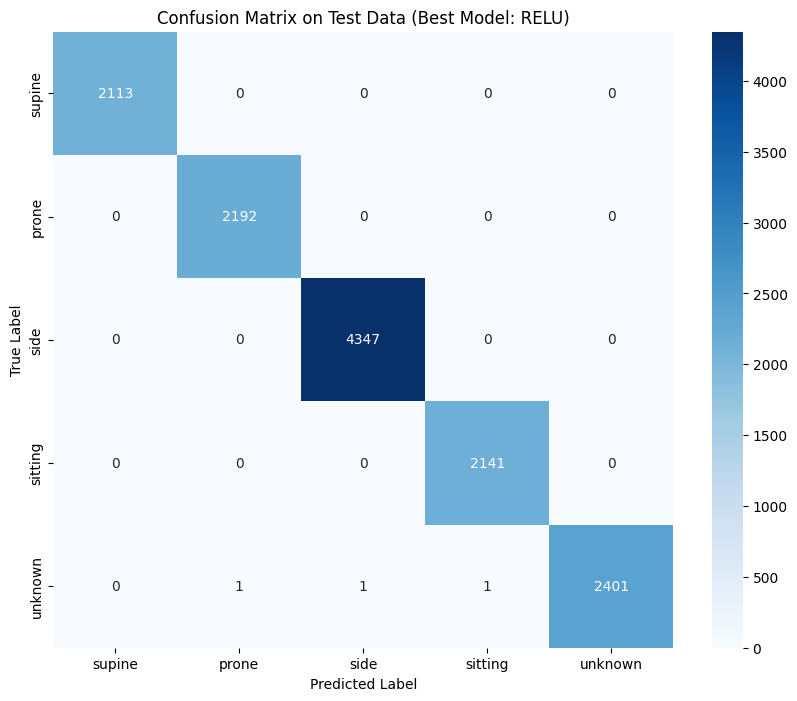

In [22]:
print("\nFinal Model Evaluation on Test Set...")

# Find the best model by looping through the histories
best_activation = ''
best_val_accuracy = 0

# Loop through the 'histories' dictionary (key=act_func, value=history)
for act_func, history in histories.items():
    # Find the best validation accuracy this model achieved
    val_acc = max(history.history['val_accuracy'])
    print(f"Model ({act_func}) best validation accuracy: {val_acc:.4f}")
    # If this model is better than the previous best, save it
    if val_acc > best_val_accuracy:
        best_val_accuracy = val_acc
        best_activation = act_func

# Get the best-performing model from my 'models' dictionary
best_model = models[best_activation]

print(f"\nEvaluating best model ({best_activation.upper()}) on unseen test data...")

# Use the best model to make predictions on the unseen X_test data
y_pred_probs = best_model.predict(X_test)

# The model outputs probabilities (e.g., [0.1, 0.8, 0.05, ...]).
# np.argmax finds the *index* (the class) with the highest probability.
y_pred = np.argmax(y_pred_probs, axis=1)

# --- Print Classification Report ---
print("\nClassification Report:")
# Get the class names in the correct order (0, 1, 2...) for the report
target_names = [name for name, num in sorted(CLASS_LABELS.items(), key=lambda item: item[1])]
# This scikit-learn tool is great for seeing precision, recall, and f1-score
print(classification_report(y_test, y_pred, target_names=target_names))

# --- Print Confusion Matrix ---
print("\nConfusion Matrix:")
# This shows me exactly where the model is getting confused
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 8))
# Use seaborn to create a nice-looking heatmap
sns.heatmap(
    cm,
    annot=True, # Show the numbers in each cell
    fmt='d',    # Format as integers
    cmap='Blues',
    xticklabels=target_names,
    yticklabels=target_names
)
plt.title(f'Confusion Matrix on Test Data (Best Model: {best_activation.upper()})')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()